# Alzheimer's MRI Image Classification Baseline

## Install and Imports

In [1]:
#install fastai2
!pip install -Uqq fastbook wandb
import fastbook

     |████████████████████████████████| 727kB 28.0MB/s 
     |████████████████████████████████| 1.8MB 44.0MB/s 
     |████████████████████████████████| 194kB 48.9MB/s 
     |████████████████████████████████| 1.2MB 43.6MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 174kB 50.7MB/s 
     |████████████████████████████████| 133kB 51.6MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 


In [2]:
#imports
from fastbook import *
from fastai.vision.all import *
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.wandb import WandbCallback

import glob
import zipfile
import numpy as np
import pandas as pd

## Dataset from Repository

Get dataset from [Pinkshepz/Alzheimers-Class](https://github.com/Pinkshepz/Alzheimers-Class). MRI images dataset are downloaded from [kaggle.com/alzheimers-dataset-4-class-of-images](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images).

In [3]:
!wget --no-check-certificate \
    "https://github.com/Pinkshepz/Alzheimers-Class/archive/refs/heads/main.zip" \
    -O "/content/alzheimers-image.zip"


zip_ref = zipfile.ZipFile('/content/alzheimers-image.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()

--2021-06-29 16:59:02--  https://github.com/Pinkshepz/Alzheimers-Class/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Pinkshepz/Alzheimers-Class/zip/refs/heads/main [following]
--2021-06-29 16:59:02--  https://codeload.github.com/Pinkshepz/Alzheimers-Class/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/alzheimers-image.zip’

/content/alzheimers     [                <=> ] 372.03M  15.8MB/s    in 24s     

2021-06-29 16:59:26 (15.8 MB/s) - ‘/content/alzheimers-image.zip’ saved [390103481]



## Prepare Train/Val Set

In [4]:
#create train/val file names and classes dataframe 
base_dirtr = '/content/Alzheimers-Class-main/Image-dataset/train/'
train_fnames = pd.DataFrame(columns=['fname', 'class'])
class_names = ['NonDemented', 'VeryMildDemented', 
               'MildDemented', 'ModerateDemented']

for class_ in class_names:
  fnames = glob.glob(base_dirtr + class_ + '/*.jpg')
  fnames_df = pd.DataFrame({'fname': fnames, 
                            'class': [class_]*len(fnames)})
  train_fnames = pd.concat([train_fnames, fnames_df], ignore_index=True)

## Create Dataloaders

In [5]:
#randomly split train-val sets with train:val = 80:20
splitter = RandomSplitter(valid_pct=0.2, seed=42)

In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x is an image; y is a single class
    get_x=ColReader(0), #x - image
    get_y=ColReader(1), #y - single class
    splitter=splitter, #split train-val
    item_tfms=Resize(224, method=ResizeMethod.Squish),
    batch_tfms=aug_transforms(size=224,),
    )

In [7]:
dls = dblock.dataloaders(train_fnames, path='.', bs=64) #batch size is 64 

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


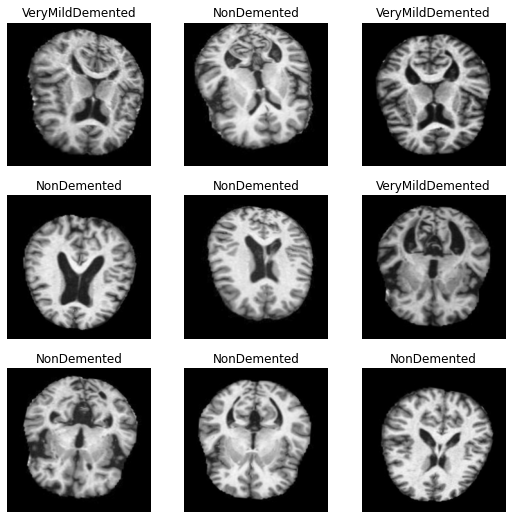

In [8]:
#preview some images
dls.train.show_batch(max_n=9, nrows=3)

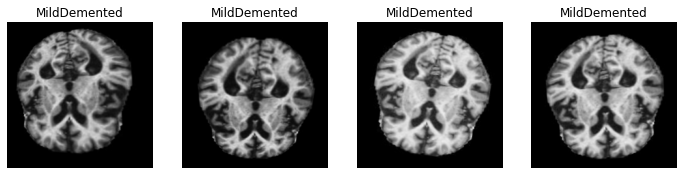

In [9]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Train Model

We utilize `resnet50` to train the model.



In [13]:
model = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy]).to_fp16()

Let's find learning rate.

SuggestedLRs(valley=tensor(0.0017))

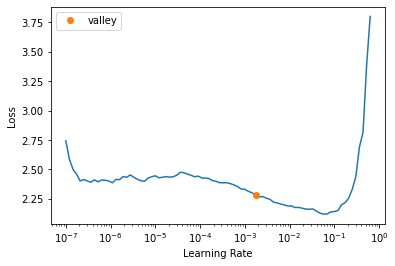

In [14]:
model.lr_find()

In [15]:
model.fine_tune(epochs=5,
                 base_lr=1e-3, #max learning rate
                 freeze_epochs=1, #epoch num to train frozen
                 lr_mult=100,
                 pct_start=0.2, 
                 div=5.0,     
                 cbs=[SaveModelCallback(monitor='accuracy'),])

epoch,train_loss,valid_loss,accuracy,time
0,1.954080,1.385044,0.494141,00:16


Better model found at epoch 0 with accuracy value: 0.494140625.


epoch,train_loss,valid_loss,accuracy,time
0,1.507953,1.056520,0.604492,00:18
1,1.301421,0.866597,0.678711,00:18
2,1.069414,0.758683,0.713867,00:18
3,0.907604,0.688622,0.736328,00:18
4,0.822073,0.679939,0.740234,00:19


Better model found at epoch 0 with accuracy value: 0.6044921875.
Better model found at epoch 1 with accuracy value: 0.6787109375.
Better model found at epoch 2 with accuracy value: 0.7138671875.
Better model found at epoch 3 with accuracy value: 0.736328125.
Better model found at epoch 4 with accuracy value: 0.740234375.


Plot train and validation losses.

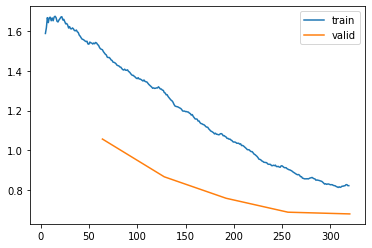

In [16]:
model.recorder.plot_loss()

Create fastai interpretation object to check validation results.

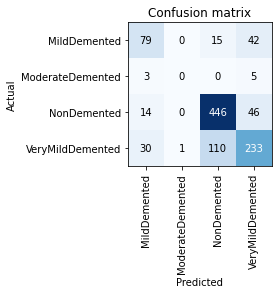

In [17]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

Preview images with top losses.

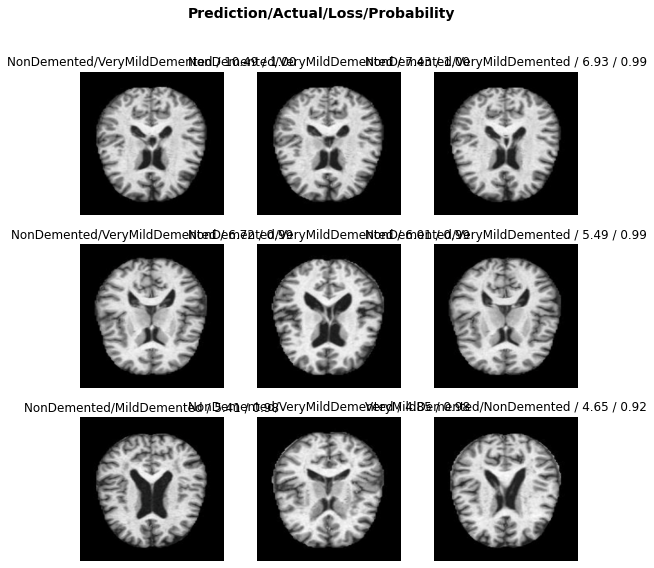

In [18]:
interp.plot_top_losses(9, nrows=3)

In [19]:
interp.print_classification_report()

                  precision    recall  f1-score   support

    MildDemented       0.63      0.58      0.60       136
ModerateDemented       0.00      0.00      0.00         8
     NonDemented       0.78      0.88      0.83       506
VeryMildDemented       0.71      0.62      0.67       374

        accuracy                           0.74      1024
       macro avg       0.53      0.52      0.52      1024
    weighted avg       0.73      0.74      0.73      1024



In [20]:
model.export()

## Test Set Evaluation

Prepare test dataset

In [21]:
base_dirtr = '/content/Alzheimers-Class-main/Image-dataset/test/'
test_fnames = pd.DataFrame(columns=['fname', 'class'])

for class_ in class_names:
  fnames = glob.glob(base_dirtr + class_ + '/*.jpg')
  fnames_df = pd.DataFrame({'fname': fnames, 
                            'class': [class_]*len(fnames)})
  test_fnames = pd.concat([test_fnames, fnames_df], ignore_index=True)

In [22]:
#preview test set dataframe
test_fnames

,fname,class
0,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/31 (16).jpg,NonDemented
1,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/31 (4).jpg,NonDemented
2,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/30 (63).jpg,NonDemented
3,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/30 (84).jpg,NonDemented
4,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/27 (55).jpg,NonDemented
...,...,...
1274,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/32 (2).jpg,ModerateDemented
1275,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/31 (2).jpg,ModerateDemented
1276,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/27 (2).jpg,ModerateDemented
1277,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/30 (2).jpg,ModerateDemented


In [23]:
#preview sizes of test set classes
test_fnames.groupby(['class']).size().reset_index()

,class,0
0,MildDemented,179
1,ModerateDemented,12
2,NonDemented,640
3,VeryMildDemented,448


In [24]:
#new datablocks and learner
splitter = RandomSplitter(valid_pct=0.99, seed=42)
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x is an image; y is a single class
    get_x=ColReader(0), #x - image
    get_y=ColReader(1), #y - single class
    splitter=splitter,
    item_tfms=Resize(224, method=ResizeMethod.Squish),
    batch_tfms=aug_transforms(size=224,),
    )

dls = dblock.dataloaders(test_fnames, bs=64) #batch size is 64

model_test = cnn_learner(dls, 
                    resnet34, 
                    metrics= [accuracy]).to_fp16()

#load trained model
model_test.load('model');

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Test set result

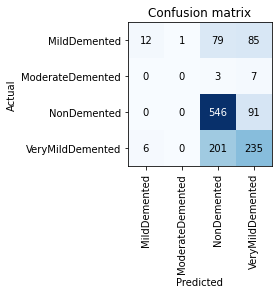

In [25]:
interp = ClassificationInterpretation.from_learner(model_test)
interp.plot_confusion_matrix()

In [26]:
interp.print_classification_report() 

                  precision    recall  f1-score   support

    MildDemented       0.67      0.07      0.12       177
ModerateDemented       0.00      0.00      0.00        10
     NonDemented       0.66      0.86      0.74       637
VeryMildDemented       0.56      0.53      0.55       442

        accuracy                           0.63      1266
       macro avg       0.47      0.36      0.35      1266
    weighted avg       0.62      0.63      0.58      1266



## Obtain labels for McNemar's Test

In [27]:
tst_dl = dls.test_dl(test_fnames, shuffle=False)

In [28]:
preds = model.get_preds(dl=tst_dl)
pred_idxs = preds[0].argmax(1)
pred_labels = [model.dls.train_ds.vocab[i] for i in pred_idxs]

In [29]:
test_df = pd.DataFrame({'fname':test_fnames.loc[:, 'fname'],
                        'Actual':test_fnames.loc[:, 'class']})

test_df["Predicted_base"] = pred_labels
test_df

,fname,Actual,Predicted_base
0,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/31 (16).jpg,NonDemented,NonDemented
1,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/31 (4).jpg,NonDemented,NonDemented
2,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/30 (63).jpg,NonDemented,NonDemented
3,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/30 (84).jpg,NonDemented,NonDemented
4,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/27 (55).jpg,NonDemented,NonDemented
...,...,...,...
1274,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/32 (2).jpg,ModerateDemented,NonDemented
1275,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/31 (2).jpg,ModerateDemented,NonDemented
1276,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/27 (2).jpg,ModerateDemented,VeryMildDemented
1277,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/30 (2).jpg,ModerateDemented,VeryMildDemented


In [31]:
def check_preds(df): return 1 if df.Actual == df.Predicted_base else 0

test_df['Score_base'] = test_df.apply(check_preds, axis=1)
test_df

,fname,Actual,Predicted_base,Score_base
0,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/31 (16).jpg,NonDemented,NonDemented,1
1,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/31 (4).jpg,NonDemented,NonDemented,1
2,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/30 (63).jpg,NonDemented,NonDemented,1
3,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/30 (84).jpg,NonDemented,NonDemented,1
4,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/27 (55).jpg,NonDemented,NonDemented,1
...,...,...,...,...
1274,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/32 (2).jpg,ModerateDemented,NonDemented,0
1275,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/31 (2).jpg,ModerateDemented,NonDemented,0
1276,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/27 (2).jpg,ModerateDemented,VeryMildDemented,0
1277,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/30 (2).jpg,ModerateDemented,VeryMildDemented,0


In [32]:
test_df.to_csv('base_preds.csv')